In [488]:
import sys
sys.path.append('..')
import config

import pandas as pd
import os
import re
from pymongo import MongoClient
import time              #for time of execution
import datetime          #for time of execution
import queue             #for multithreading
import threading         #for multithreading
import inspect           #for fit
import numpy as np       #for fit
import warnings          #for fit
import scipy.optimize as optimization       #for fit
from scipy.optimize import OptimizeWarning  #for fit
warnings.simplefilter(action='ignore', category=OptimizeWarning)  #for fit
import matplotlib.pyplot as plt             #for fit visualization
import seaborn as sns                       #for fit visualization

# Connect to MongoDB
client = MongoClient(config.__host, config.__port)


In [404]:
DATA_DIR = "./data/stanford"
RESULTS_DIR = "./results_stanford"
__db_name = "scipub_stanford"

def makedir(path):
    if not os.path.exists(path):
        os.makedirs(path)
    return

makedir(RESULTS_DIR)
print('Is connection estabilished? {0}'.format(client[config.__db_name][config.__collection_name].count_documents({}) != 0))


## Create database on mongo

In [313]:
links = pd.read_csv(DATA_DIR+"/cit-HepTh.txt", sep="\t", skiprows=3)
links.columns = ['FromNodeId', 'ToNodeId']
links[:3]

,FromNodeId,ToNodeId
0,1001,9304045
1,1001,9308122
2,1001,9309097


In [575]:
def shorten_author(mystring):
    result = mystring.split(' ')
    if len(result) != 1 :
        res = ""
        for item in result[:-1]:
            if (len(item) == 2) and item[1] == '.':
                res += item
            else:
                result_2 = item.split('.')
                for item_2 in result_2:
                    if len(item_2) == 2:
                        res += item_2
                    elif len(item_2) > 0:
                        res += item_2[0]+"."
        res += result[-1]
    else:
        res = mystring[:]
    return res

def parse_document(filename):
    with open(filename) as f:
        status = 0
        paper_id = 0
        title = ""
        authors = []
        venue = ""
        for line in f:
            if((status == 0) and (line[:14] == "Paper: hep-th/")):
                paper_id = int(line[14:-1])
                status = 1
            elif(status == 1):
                if(line[:7] == "Title: "):
                    title = line[7:-1]
                    status = 2
            elif(status == 2):
                if(line[:2] == "  "):
                    title += line[2:-1]
                else:
                    status = 3
            if(status == 3):
                if(line[:9] == "Authors: "):
                    authors = line[9:-1]
                    status = 4
                elif(line[:8] == "Author: "):
                    authors = line[8:-1]
                    status = 4
            elif(status == 4):
                if(line[:2] == "  "):
                    authors += line[2:-1]
                else:
                    #clean authors
                    #remove parentheses
                    texts_in_parentheses = re.findall(re.compile(".*?\((.*?)\)"), authors)
                    for text in texts_in_parentheses:
                        authors = authors.replace(" ("+text+")", '')
                    #split authors
                    authors = authors.split(', ')
                    if ' and ' in authors[-1]:
                        authors = authors[:-1] + authors[-1].split(' and ')
                    if(authors[-1][:4] == "and "):
                        authors[-1] = authors[-1][4:]
                    status = 5
            if(status == 5):
                if(line[:13] == "Journal-ref: "):
                    #clean venue
                    venue = re.findall(re.compile("\A(.*?)[0-9]"), line[13:])
                    if venue != []:
                        venue = venue[0].replace(' ', '')
                        if len(venue) > 2:
                            if (venue[-1] != '.') and (venue[-2] == '.'):
                                venue = venue[:-1]
                        else:
                            venue = ""
                    else:
                        venue = ""
                    status = 6
    res = {"_id": paper_id, "title": title, "authors_original": authors}
    #shorten authors
    authors_short = []
    for author in authors:
        authors_short += [shorten_author(author)]
    res["authors"] = authors_short
    if venue != "":
        res["venue"] = venue
    return res

def parse_documents_in_year(year, directory):
    local_dir = directory+str(year)
    res = []
    for filename in os.listdir(local_dir):
        parse_result = parse_document(local_dir+"/"+filename)
        parse_result["year"] = year
        parse_result["cited_by"] = links[links["ToNodeId"] == parse_result["_id"]]["FromNodeId"].tolist()
        res += [parse_result]
    return res

def expand_citations_data(local_collection, lookup_collection_name):
    pipeline = [
                {'$unwind': '$cited_by'}, 
                {'$lookup': { 'from': lookup_collection_name, 'localField': 'cited_by', 'foreignField': '_id', 'as': 'cited_by'}},
                {'$unwind': '$cited_by'},
                {'$project': {'_id': '$_id', 'title': '$title', 'authors_original': '$authors_original', 'authors': '$authors', 'year': '$year', 'venue': '$venue', 'cited_by': {'_id': '$cited_by._id', 'authors': '$cited_by.authors', 'year': '$cited_by.year', 'venue': '$cited_by.venue'}}},
                {'$group': {'_id': "$_id", 'title': {'$first': '$title'}, 'authors_original': {'$first': '$authors_original'}, 'authors': {'$first': '$authors'}, 'year': {'$first': '$year'}, 'venue': {'$first': '$venue'}, 'cited_by': {'$push': '$cited_by'}}},
    ]

    result = local_collection.aggregate(pipeline, allowDiskUse=True)
    return result


In [576]:
collection_name = "papers"
collection_name_tmp = collection_name+"_tmp"

#create temp collection with data on papers
client[__db_name][collection_name_tmp].drop()
dataset_dir = DATA_DIR+"/cit-HepTh-abstracts/"
start_time = time.mktime(time.localtime())
print("start @ ", time.ctime())
for year in os.listdir(dataset_dir):
    res = parse_documents_in_year(int(year), dataset_dir)
    client[__db_name][collection_name_tmp].insert_many(res)
print("end @ ", time.ctime(), " - total time ", datetime.timedelta(seconds=time.mktime(time.localtime())-start_time), " - documents : ", client[__db_name][collection_name_tmp].count_documents({}))


#create collection with data on papers and full data on citations
client[__db_name][collection_name].drop()

#insert papers with citations
start_time = time.mktime(time.localtime())
print("start @ ", time.ctime())
res = list(expand_citations_data(client[__db_name][collection_name_tmp], collection_name_tmp))
client[__db_name][collection_name].insert_many(res)
print("end @ ", time.ctime(), " - total time ", datetime.timedelta(seconds=time.mktime(time.localtime())-start_time), " - documents : ", client[__db_name][collection_name].count_documents({}))

#insert papers without citations
res = list(client[__db_name][collection_name_tmp].find({'cited_by': []}))
client[__db_name][collection_name].insert_many(res)

print("Documents in collection", collection_name+":", client[__db_name][collection_name].count_documents({}))
client[__db_name][collection_name_tmp].drop()

start @  Fri Feb  1 15:03:51 2019
end @  Fri Feb  1 15:04:13 2019  - total time  0:00:22  - documents :  29555
start @  Fri Feb  1 15:04:13 2019
end @  Fri Feb  1 15:04:47 2019  - total time  0:00:34  - documents :  23180
Documents in collection papers: 29555


## Create scores

In [338]:
main_collection_name = "papers"

initial_years = [1992, 1994]
influence_years = [1995, 2003]
max_time_window_size = 6

In [711]:

####################### Calculate raw data for scores ###########################

#papers written by a list of items, with the year of publication
def list_of_papers(list_of_items, field_name, range_of_years=None, local_collection=papers_collection):
    if len(list_of_items) == 0:
        return {}
    pipeline = [
            {'$match': {field_name: {'$in': list_of_items}}}, 
    ]
    
    if range_of_years != None:
        pipeline = [
                    {'$match': {'year': {'$gte': range_of_years[0], '$lte': range_of_years[1]}}}, 
        ] + pipeline
        
    return local_collection.aggregate(pipeline)

#calculate time windows from interval
def get_time_windows(year_from, year_to, time_window_size, overlap):
    if overlap >= time_window_size:
        return []
    time_window_size-=1; overlap -= 1; year_to+= 1
    res = []
    i = 0
    while (year_from + i*(time_window_size-overlap) + time_window_size) < year_to:
        res += [[year_from + i*(time_window_size-overlap), year_from + i*(time_window_size-overlap) + time_window_size]]
        i += 1
    return res

#citations received by a list of papers, grouped by year
#  trace_single to True if the citations must be count singularly for each paper on list
#  -> if False, when a paper cites more than one paper of the list, it is counted only once;
#  count_papers_in_list to False if papers in list_of_id must not be counted in citations
#  count_only_first to True if the papers must be counted only the first time they cite the source paper
def paper_citations_by_year(list_of_id, range_of_years=None, count_papers_in_list=True, trace_single=False, count_only_first=False, local_collection=papers_collection):
    #"""
    if len(list_of_id) == 0:
        return {}
    elif len(list_of_id) == 1:
        pipeline = [
                    {'$match': {'_id': list_of_id[0]}}, 
        ]
    else:
        pipeline = [
                    {'$match': {'_id': {'$in': list_of_id}}}, 
        ]

    pipeline = pipeline + [
                {'$unwind': '$cited_by'}, 
    ]
    
    if not(count_papers_in_list):
        pipeline = pipeline + [
                    {'$match': {'cited_by._id': {'$nin': list_of_id}}},
        ]
    
    if range_of_years != None:
        pipeline = pipeline + [
                    {'$match': {'cited_by.year': {'$gte': range_of_years[0], '$lte': range_of_years[1]}}}, 
        ]
    
    if trace_single:
        pipeline = pipeline + [
                    {'$project': {'_id' :0, '_id': '$cited_by._id', 'year': '$cited_by.year', 'authors': '$cited_by.authors', 'cites': '$_id'}},
                    {'$sort': {'cites':1, 'year': 1}}
        ]
        if count_only_first:
            pipeline = pipeline + [
                        {'$group': {'_id' : {'_id': '$_id', 'cites': '$cites'}, 'year': { '$first': '$year' }, 'authors': { '$first': '$authors' }}},
                        {'$project': {'_id' :0, '_id': '$_id._id', 'cites': '$_id.cites', 'year': '$year', 'authors': '$authors'}},
            ]
    else:
        pipeline = pipeline + [
                    {'$project': {'_id' :0, '_id': '$cited_by._id', 'year': '$cited_by.year', 'authors': '$cited_by.authors'}},
                    {'$sort': {'year': 1}}
        ]
        if count_only_first:
            pipeline = pipeline + [
                        {'$group': {'_id' : '$_id', 'year': { '$first': '$year' }, 'authors': { '$first': '$authors' }}},
                        {'$project': {'_id' :1, 'year': '$year', 'authors': '$authors'}},
            ]

    return local_collection.aggregate(pipeline, allowDiskUse=True)

#papers written by a list of authors, with the year of first (or last) publication
def list_of_authors(list_of_papers=None, range_of_years=None, local_collection=papers_collection):
    pipeline = [
            {'$project': {'_id' :0, 'authors': 1, 'year': 1}},
            {'$unwind': '$authors'}, 
            {'$sort': {'authors': 1, 'year': 1}},
            {'$group': {'_id' : '$authors', 'year_first': {'$first': '$year'}, 'year_last': {'$last': '$year'} }},
            {'$project': {'_id' :0, 'author': '$_id', 'year_first': '$year_first', 'year_last': '$year_last', 'range_of_years': {'$subtract': [ "$year_last", "$year_first" ]} }},
    ]

    if range_of_years != None:
        pipeline = [
                    {'$match': {'year': {'$gte': range_of_years[0], '$lte': range_of_years[1]}}}, 
        ] + pipeline

    if list_of_papers != None:
        pipeline = [
                    {'$match': {'_id': {'$in': list_of_papers}}}, 
        ] + pipeline
        
    return local_collection.aggregate(pipeline, allowDiskUse=True)

#
# layer 0 shows the initial data
def get_windows_authors(initial_papers, time_windows, local_collection=papers_collection):
    res = {"layer":[], "number_of_papers":[], "number_of_authors":[], "number_of_new_authors":[]} #pd.DataFrame( {"layer":[], "acm_id":[]} )
    if initial_papers == []:
        return res
    #exclude initial papers from results
    excluded_papers = initial_papers[:]
    excluded_authors = [x['author'] for x in list(list_of_authors(list_of_papers=initial_papers, local_collection=local_collection))]
    #add data on initial layer
    res["layer"] += [0]
    res["number_of_papers"] += [len(initial_papers)]
    res["number_of_authors"] += [len(excluded_authors)]
    res["number_of_new_authors"] += [0]
    for index, time_window in enumerate(time_windows):
        paper_citations_in_year = list(paper_citations_by_year(initial_papers, range_of_years=time_window, count_papers_in_list=True, trace_single=False, count_only_first=True, local_collection=local_collection))
        paper_citations = [x['_id'] for x in paper_citations_in_year if x['_id'] not in excluded_papers]
        if paper_citations == []:
            return res
        res["layer"] += [index+1]
        res["number_of_papers"] += [len(paper_citations)]
        #add authors
        authors = [x['authors'] for x in paper_citations_in_year]
        authors = list(set([item for sublist in authors for item in sublist]))
        res["number_of_authors"] += [len(authors)]
        #add new authors
        new_authors = [x for x in authors if x not in excluded_authors]
        res["number_of_new_authors"] += [len(new_authors)]
        #reset initial papers and excluded papers
        initial_papers = paper_citations[:]
        if initial_papers == []:
            return res
        excluded_papers += initial_papers
        excluded_authors += new_authors
    return res

def create_our_scores(field_name, list_of_items, __db_name, experiment_collection_name, influence_years, max_time_window_size):
    class myThread (threading.Thread):
        def __init__(self, threadID, q):
            threading.Thread.__init__(self)
            self.thread_id = threadID
            self.q = q
        def run(self):
            process_data(self.thread_id, self.q)      

    def process_data(thread_id, q):
        exitFlag = False
        while not exitFlag:
            queueLock.acquire()
            if not workQueue.empty():
                data = q.get()
                queueLock.release()
                #exec
                if len(data) == 2:
                    exec_and_insert(thread_id, data[0], data[1])
            else:
                queueLock.release()
                exitFlag = True

    #insert data of time windows in new collection
    def exec_and_insert(thread_id, time_window_size, overlap):
        res = get_time_windows(influence_years[0], influence_years[1], time_window_size, overlap)
        if len(res) > 1:
            start_time = time.mktime(time.localtime())
            printLock.acquire()
            print("TW:", time_window_size, "OV:", overlap, "th:", str(thread_id), "- start @", time.ctime())
            printLock.release()
            number_of_fits = 0
            time_windows = get_time_windows(influence_years[0], influence_years[1], time_window_size, overlap)
            for item in list_of_items:
                list_of_id = [x['_id'] for x in list(list_of_papers([item], field_name, range_of_years=initial_years, local_collection=client[__db_name][main_collection_name]))]
                res = get_windows_authors(list_of_id, time_windows, local_collection=client[__db_name][main_collection_name])
                res["_id"] = str(item)+"-"+str(time_window_size)+"-"+str(overlap)
                if field_name != "_id":
                    res[field_name] = item
                else:
                    res["original_id"] = item
                res["time_window_size"] = time_window_size
                res["overlap"] = overlap
                #add fit
                fit = get_all_fits(res, func_line)
                if fit != {}:
                    res["fit"] = fit
                    number_of_fits += 1
                #store
                client[__db_name][experiment_collection_name].insert_one(res)
            printLock.acquire()
            print("TW:", time_window_size, "OV:", overlap, "th:", str(thread_id), "- end @", time.ctime(), "- total time", datetime.timedelta(seconds=time.mktime(time.localtime())-start_time), "- documents", client[__db_name][experiment_collection_name].count_documents({'time_window_size': time_window_size, 'overlap': overlap}), "- scores:", number_of_fits)
            printLock.release()
        return


    #create new collection
    client[__db_name][experiment_collection_name].drop()
    print("Documents in collection", experiment_collection_name+":", client[__db_name][experiment_collection_name].count_documents({}),"\n")

    number_of_threads = 10
    queueLock = threading.Lock()
    printLock = threading.Lock()
    workQueue = queue.Queue(30)
    threads = []
    threadID = 1

    # Fill the queue
    for time_window_size in range(max_time_window_size+1):
        for overlap in range(time_window_size):
            workQueue.put([time_window_size, overlap])

    # Create new threads
    init_time = time.mktime(time.localtime())
    for thread_id in range(number_of_threads):
        thread = myThread(thread_id, workQueue)
        thread.start()
        threads.append(thread)

    # Wait for all threads to complete
    for t in threads:
        t.join()
    print("\nExiting Main Thread")

    print("Documents in collection", experiment_collection_name+":", client[__db_name][experiment_collection_name].count_documents({}))

    print("\n ### END of procedure! - Total Execution:", datetime.timedelta(seconds=time.mktime(time.localtime())-init_time))
    return

####################### Fit procedure ###########################

#linear function
def func_line(x, a, b):
    return a*x + b

#calculate fit
def get_fit(data, fit_func):
    result = {}
    try:
        popt, pcov = optimization.curve_fit(fit_func, range(len(data)), data)
        result["params"] = list(popt)
        result["stderr"] = list(np.sqrt(np.diag(pcov)))
    except:
        print("Exception for fitting:", data)
    return result

def get_all_fits(document, fit_func, add_missing_data=True):
    result = {}
    for column in ["number_of_authors", "number_of_new_authors", "number_of_papers"]:
        data = document[column][1:]
        if len(data) >= 2:
            if add_missing_data:
                if document["time_window_size"]:
                    data = data + [0]*(len(get_time_windows(influence_years[0], influence_years[1], document["time_window_size"], document["overlap"]))-len(data))
                else:
                    data = data + [0]*(influence_years[1]-influence_years[0]+1-len(data))
            result[column] = get_fit(np.cumsum(data), func_line)
    return result


####################### Select parameters ###########################

#get DataFrame of fit values for each time window
def fit_overview(topic, local_collection):
    pipeline = [
        {'$match': {'overlap': {'$exists': True}}}, 
        {'$project': {'_id':0, topic:1, 'experiment': { '$concat': [ {'$substr': ["$time_window_size", 0, -1 ]}, " - ", {'$substr': ["$overlap", 0, -1 ]}] }, 'overlap': 1, 'time_window_size': 1}} 
    ]
    
    for item in["number_of_new_authors", "number_of_authors", "number_of_papers"]:
        for index, item_2 in enumerate(["a", "b"]):
            pipeline[-1]['$project'][item+"_"+item_2] = {'$arrayElemAt': ['$fit.'+item+'.params', index]}
    
    return pd.DataFrame(list(local_collection.aggregate(pipeline, allowDiskUse=True)))

#get correlations among time windows
def TW_correlations(main_topic, local_collection):
    fit_df = fit_overview(main_topic, local_collection)
    tmp = fit_df[[main_topic, "experiment", "number_of_new_authors_a"]].pivot(index=main_topic, columns="experiment", values="number_of_new_authors_a").dropna(thresh=1)
    print("### Considering the", len(tmp), "items having at least one parameter")
    correlations = []
    for item_1 in tmp.columns:
        list_of_correlations = []
        number_of_items = []
        for item_2 in tmp.columns:
            if item_1 != item_2:
                tmp_loc = tmp[[item_1, item_2]].dropna()
                number_of_items += [len(tmp_loc)]
                list_of_correlations += [tmp_loc[item_1].corr(tmp_loc[item_2], method='spearman')]
        correlations += [{"experiment": item_1, "mean": np.mean(list_of_correlations), "std": np.std(list_of_correlations), "time_window_size": int(item_1[0]), "overlap": int(item_1[-1])}]
    return correlations

#plot heatmap
def plot_heatmap(df, use_index=False, type=None, highlight_diagonal=True, show_values=False, fmt = '.0f', cbar=True, columns=None, partitions=[], figsize=(8,8), filename=""):
    fig = plt.figure(figsize = figsize)
    
    mask = np.zeros_like(np.array(df))
    if type == "diag":
        mask[np.diag_indices_from(mask)] = True
    elif type == "upper":
        mask[np.triu_indices_from(mask)] = True
        mask[np.diag_indices_from(mask)] = False
    elif type == "lower":
        mask[np.tril_indices_from(mask)] = True
    
    to_plot = df.copy()
    if use_index:
        ax = sns.heatmap(to_plot, square=1, linewidth=1., mask=mask, annot=show_values, fmt = fmt, cmap="Greens", cbar=cbar)#, xticklabels=ticklabels, yticklabels=ticklabels)
    else:
        ax = sns.heatmap(to_plot[to_plot.columns[1:]], square=1, linewidth=1., vmin=0, mask=mask, annot=show_values, fmt = fmt, cmap="Greens")#, xticklabels=ticklabels, yticklabels=ticklabels)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    
    if highlight_diagonal:
        number_of_items = len(df)
        for index in range(number_of_items):
            ax.add_patch(Rectangle((number_of_items-index-1, index), 1, 1, fill=False, edgecolor='lightgrey', lw=2))
    #highlight partitions
    if partitions:
        for partition in partitions:
            ax.add_patch(Rectangle((partition[0], len(to_plot)-partition[1]-1), (partition[1] - partition[0] + 1), (partition[1] - partition[0] + 1), fill=False, edgecolor='black', lw=2))
    
    ax.set(title='', xlabel=r'Length of Overlap ($\gamma$)', ylabel=r'Length of Time Window ($\delta$)')
    
    #save
    if filename != "":
        plt.savefig(filename, bbox_inches='tight', dpi=160)
    #plot
    plt.show()
    return


####################### Other scores ###########################

## venues

def get_topics_score(param_name, param_index, time_window_size, overlap, topic, local_collection):
    pipeline = [
        { '$match': {'time_window_size': time_window_size, 'overlap': overlap} },
        { '$project': {'_id':0, topic:1, 'param': { "$arrayElemAt": [ '$fit.'+param_name+'.params', param_index ]}, 'overlap': 1, 'time_window_size': 1, 'h_index': 1, 'h_index_local': 1} },
        { '$sort' : {'param': -1}}
    ]
    return local_collection.aggregate(pipeline, allowDiskUse=True)

def get_number_citations_received(topic, range_of_years, local_collection=papers_collection):
    pipeline = [
            {'$project': { '_id': 0, topic: 1, 'cited_by': 1 }},
            {'$unwind': '$cited_by' },
            {'$project': { topic: 1, 'year_of_citation': '$cited_by.year' }},
            {'$match': { 'year_of_citation': {'$gte': range_of_years[0], '$lte': range_of_years[1]} }}, 
            {'$group': { '_id': '$'+topic, 'count': { '$sum': 1} }}, 
            {'$project': { '_id': 0, topic: '$_id', 'citations_received': '$count' }},
            {'$sort': { 'citations_received': -1 }},
    ]
    return local_collection.aggregate(pipeline)

#calculate scores of venues
def get_score_venues(main_topic, best_parameters, __db_name, main_collection_name, experiment_collection_name):
    tmp = pd.DataFrame(list(get_topics_score("number_of_new_authors", 0, best_parameters[0], best_parameters[1], main_topic, local_collection=client[__db_name][experiment_collection_name])))[[main_topic, "param"]]#.sort_values(by="param", ascending=False)
    tmp = tmp.merge(pd.DataFrame(list(get_number_citations_received("venue", influence_years, local_collection=client[__db_name][main_collection_name]))), how="outer")#.fillna(0)
    #add number of paper published by each journal/conference in initial_years
    tmp = tmp.merge(pd.DataFrame(list(client[__db_name][experiment_collection_name].aggregate([
        {'$match': {'time_window_size': best_parameters[0], 'overlap': best_parameters[1] }},
        {'$project': {'_id':0, 'venue': 1, 'number_of_published_papers': { '$arrayElemAt': [ '$number_of_papers', 0 ]} }},
        {'$match': {'number_of_published_papers': { '$exists' :True} }},
    ]))),
             how="left")
    #add a calculation similar to citescore: https://www.elsevier.com/editors-update/story/journal-metrics/citescore-a-new-metric-to-help-you-choose-the-right-journal
    tmp["custom_citescore"] = tmp["citations_received"]/(tmp["number_of_published_papers"]*(influence_years[1] - influence_years[0] + 1))
    return tmp

## authors

def get_authors_score(param_name, param_index, time_window_size, overlap, topic, N, local_collection):
    pipeline = [
        { '$match': {'time_window_size': time_window_size, 'overlap': overlap} },
        { '$project': {'_id':0, topic:1, 'param': { "$arrayElemAt": [ '$fit.'+param_name+'.params', param_index ]}, 'overlap': 1, 'time_window_size': 1, 'h_index': 1, 'h_index_local': 1, 'g_index': 1, 'g_index_local': 1, 'i'+str(N)+'_index': 1, 'i'+str(N)+'_index_local': 1, 'm_index': 1, 'm_index_local': 1} },
        { '$sort' : {'param': -1}}
    ]
    return local_collection.aggregate(pipeline, allowDiskUse=True)

#number of citations of the papers made by an author
def number_of_citations(author, range_of_years=None, range_of_years_citations=None, local_collection=papers_collection):
    pipeline = []
    
    if range_of_years != None:
        pipeline = pipeline + [
                    {'$match': {'year': {'$gte': range_of_years[0], '$lte': range_of_years[1]}}}, 
        ] + pipeline
        
    pipeline = pipeline + [
            {'$match': {'authors': {'$in': [author]}}}, 
    ]
    
    if range_of_years_citations != None:
        pipeline = [
                    {'$match': {'cited_by.year': {'$gte': range_of_years_citations[0], '$lte': range_of_years_citations[1]}}}, 
        ] + pipeline
    
    pipeline = pipeline + [
            {'$project': {'_id':0, 'number_of_citations': { '$size': "$cited_by" } }},
            {'$sort': {'number_of_citations': -1}}
    ]
    
    return [x['number_of_citations'] for x in local_collection.aggregate(pipeline)]

#calculate h index from the number of citations received by each paper
def get_h_index(citations):
    return sum(x >= i + 1 for i, x in enumerate(sorted(citations, reverse=True)))

#calculate the cumulatove fo a list
def get_cumulative(list_of_numbers):
    total_sum = 0
    res = []
    #for index in range(len(list_of_numbers)):
    for item in list_of_numbers:
        total_sum += item
        res += [total_sum]
    return res
        

#calculate h index from the number of citations received by each paper
def get_g_index(citations):
    return sum(x > (i + 1)*(i + 1) for i, x in enumerate(get_cumulative(sorted(citations, reverse=True))))

#calculate iN index (number of publications with at least N citations) from the number of citations received by each paper
def get_iN_index(N, citations):
    return sum(x >=N for x in citations)

#calculate m index from the number of citations received by each paper: https://slideplayer.com/slide/6912089/
def get_m_index(citations):
    res = [x for i, x in enumerate(sorted(citations, reverse=True)) if (x>= i + 1)]
    if res == []:
        return 0
    return np.median(res)

#set other indexes of each author
def create_other_indexes_authors(field_name, list_of_authors, N, __db_name, main_collection_name, experiment_collection_name, initial_years, influence_years, max_time_window_size):
    class myThread(threading.Thread):
        def __init__(self, threadID, q):
            threading.Thread.__init__(self)
            self.thread_id = threadID
            self.q = q
        def run(self):
            process_data(self.thread_id, self.q)

    def process_data(thread_id, q):
        exitFlag = False
        while not exitFlag:
            queueLock.acquire()
            if not workQueue.empty():
                data = q.get()
                queueLock.release()
                #exec
                exec_and_insert(thread_id, data)
            else:
                queueLock.release()
                exitFlag = True

    #insert data of time windows in new collection
    def exec_and_insert(thread_id, author):
        """
        printLock.acquire()
        print(author)
        printLock.release()
        """
        citations_local = number_of_citations(author, range_of_years=[initial_years[0], influence_years[1]], range_of_years_citations=[initial_years[0], influence_years[1]], local_collection=client[__db_name][main_collection_name])
        citations_global = number_of_citations(author, local_collection=client[__db_name][main_collection_name])
        h_index_local = get_h_index(citations_local)
        h_index_global = get_h_index(citations_global)
        g_index_local = get_g_index(citations_local)
        g_index_global = get_g_index(citations_global)
        iN_index_local = get_iN_index(N, citations_local)
        iN_index_global = get_iN_index(N, citations_global)
        m_index_local = get_m_index(citations_local)
        m_index_global = get_m_index(citations_global)        
        client[__db_name][experiment_collection_name].update_many({field_name: author}, {'$set': {
            'h_index_local': h_index_local, 'h_index': h_index_global,
            'g_index_local': g_index_local, 'g_index': g_index_global,
            'i'+str(N)+'_index_local': iN_index_local, 'i'+str(N)+'_index': iN_index_global,
            'm_index_local': m_index_local, 'm_index': m_index_global
        } } )
        return


    # Variables for threads
    number_of_threads = 10
    queueLock = threading.Lock()
    printLock = threading.Lock()
    workQueue = queue.Queue(len(list_of_authors))
    threads = []

    # Fill the queue
    for name in list_of_authors:
        workQueue.put(name)

    print("Start execution\n")
    init_time = time.mktime(time.localtime())
    # Create new threads
    for thread_id in range(number_of_threads):
        thread = myThread(thread_id, workQueue)
        thread.start()
        threads.append(thread)

    # Wait for all threads to complete
    for t in threads:
        t.join()
    print("\nExiting Main Thread")

    print("\n ### END of procedure! - Total Execution:", datetime.timedelta(seconds=time.mktime(time.localtime())-init_time))
    return

#number of papers written by each author
def number_of_papers(range_of_years=None, local_collection=papers_collection):
    pipeline = [
            {'$project': {'_id' :0, 'authors': 1, 'year': 1}},
            {'$unwind': '$authors'}, 
            {'$group': {'_id' : '$authors', 'count': { '$sum': 1 }}},
            {'$project': {'_id' :0, 'author': '$_id', 'count': '$count'}},
    ]

    if range_of_years != None:
        pipeline = [
                    {'$match': {'year': {'$gte': range_of_years[0], '$lte': range_of_years[1]}}}, 
        ] + pipeline
        
    return local_collection.aggregate(pipeline, allowDiskUse=True)

#calculate scores of authors
def get_score_authors(main_topic, best_parameters, N, __db_name, main_collection_name, experiment_collection_name):
    tmp = pd.DataFrame(list(get_authors_score("number_of_new_authors", 0, best_parameters[0], best_parameters[1], main_topic, N, local_collection=client[__db_name][experiment_collection_name]))).rename(columns={main_topic: "author"})
    #range of years - total
    tmp = tmp.merge(pd.DataFrame(list(list_of_authors(local_collection=client[__db_name][main_collection_name]))), how="left")
    #range of years - only in the time window under study
    tmp = tmp.merge(pd.DataFrame(list(list_of_authors(range_of_years=[initial_years[0], influence_years[1]], local_collection=client[__db_name][main_collection_name]))).rename(columns={"year_first": "year_first_local", "year_last": "year_last_local", "range_of_years": "range_of_years_local"}), how="left")
    #number of publications - total
    tmp = tmp.merge(pd.DataFrame(list(number_of_papers(local_collection=client[__db_name][main_collection_name]))).rename(columns={"count": "number_of_papers"}), how="left")
    #number of publications - only in the time window under study
    tmp = tmp.merge(pd.DataFrame(list(number_of_papers(range_of_years=[initial_years[0], influence_years[1]], local_collection=client[__db_name][main_collection_name]))).rename(columns={"count": "number_of_papers_local"}), how="left")
    return tmp

####################### Plot correlations ###########################


def plot_local(df, number_of_items):
    fig = plt.figure(figsize = (3,4))
    ax = plt.gca()
    for score in df["score"].unique():
        to_plot = df[df["score"] == score]
        color = "grey" if (score != "param") else "royalblue"
        label = score if (score != "param") else "our"
        plt.plot(range(len(to_plot)), to_plot["value"], linewidth=2, color=color)
        shift = 0 if (score != "param") else 0.01
        ax.text(len(to_plot)-0.9, list(to_plot["value"])[-1]-shift, label, weight='bold', ha="left", color=color, size=12) #ax.text(len(to_plot)+0.2, to_plot["value"][-1], label, ha="center") 
    plt.xticks(range(len(to_plot)), to_plot["feature"], rotation='vertical')
    if ax.get_ylim()[0] > 0:
        ax.set_ylim([0,ax.get_ylim()[1]])
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.title("Spearman correlation\n-for "+str(number_of_items)+" items-")
    plt.show()
    return


def plot_correlations(df):
    fig = plt.figure(figsize = (3,4))
    ax = plt.gca()
    for score in df["score"].unique():
        #print(score)
        to_plot = df[df["score"] == score]
        color = "grey" if (score != "param") else "royalblue"
        label = "baseline" if (score != "param") else "our"
        plt.plot(to_plot["value"], range(len(to_plot)), 'o', color=color)
    plt.yticks(range(len(to_plot)), to_plot["feature"])#, rotation='vertical')
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.title("Spearman correlation")
    plt.show()
    return

### Venues

In [384]:
field_name = "venue"

list_of_items = [x['_id'] for x in list(client[__db_name][main_collection_name].aggregate([
    {'$project': {field_name: 1 }}, 
    {"$match": {field_name: {'$exists': True, '$ne': None} }},
    {'$sortByCount': '$'+field_name },
    {'$match': {'count': {'$gte': 10}}}
]))]
print(len(list_of_items), field_name, "contained on dataset")

experiment_collection_name = main_collection_name+"-experiment-"+str(initial_years[0])+"_"+str(initial_years[1])+"-"+str(influence_years[0])+"_"+str(influence_years[1])+"-"+field_name
experiment_collection_name

50 venue contained on dataset


'papers-experiment-1992_1994-1995_2003-venue'

In [387]:
create_our_scores(list_of_items, __db_name, experiment_collection_name, influence_years, max_time_window_size)

Documents in collection papers-experiment-1992_1994-1995_2003-venue: 0 

TW: 1 OV: 0 th: 0 - start @ Thu Jan 31 12:55:47 2019
TW: 2 OV: 0 th: 1 - start @ Thu Jan 31 12:55:47 2019
TW: 2 OV: 1 th: 2 - start @ Thu Jan 31 12:55:47 2019
TW: 3 OV: 0 th: 3 - start @ Thu Jan 31 12:55:47 2019
TW: 3 OV: 1 th: 4 - start @ Thu Jan 31 12:55:47 2019
TW: 3 OV: 2 th: 5 - start @ Thu Jan 31 12:55:47 2019
TW: 4 OV: 0 th: 6 - start @ Thu Jan 31 12:55:47 2019
TW: 4 OV: 1 th: 7 - start @ Thu Jan 31 12:55:47 2019
TW: 4 OV: 2 th: 8 - start @ Thu Jan 31 12:55:47 2019
TW: 4 OV: 3 th: 9 - start @ Thu Jan 31 12:55:47 2019


/home/livio/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


TW: 4 OV: 1 th: 7 - end @ Thu Jan 31 12:56:55 2019 - total time 0:01:08 - documents 50 - scores: 35
TW: 5 OV: 1 th: 7 - start @ Thu Jan 31 12:56:55 2019
TW: 4 OV: 0 th: 6 - end @ Thu Jan 31 12:56:58 2019 - total time 0:01:11 - documents 50 - scores: 35
TW: 5 OV: 2 th: 6 - start @ Thu Jan 31 12:56:58 2019
TW: 3 OV: 0 th: 3 - end @ Thu Jan 31 12:57:44 2019 - total time 0:01:57 - documents 50 - scores: 34
TW: 5 OV: 3 th: 3 - start @ Thu Jan 31 12:57:44 2019
TW: 5 OV: 1 th: 7 - end @ Thu Jan 31 12:58:05 2019 - total time 0:01:10 - documents 50 - scores: 35
TW: 5 OV: 4 th: 7 - start @ Thu Jan 31 12:58:05 2019
TW: 5 OV: 2 th: 6 - end @ Thu Jan 31 12:58:10 2019 - total time 0:01:12 - documents 50 - scores: 35
TW: 6 OV: 3 th: 6 - start @ Thu Jan 31 12:58:11 2019
TW: 2 OV: 0 th: 1 - end @ Thu Jan 31 12:58:21 2019 - total time 0:02:34 - documents 50 - scores: 34
TW: 6 OV: 4 th: 1 - start @ Thu Jan 31 12:58:21 2019
TW: 4 OV: 2 th: 8 - end @ Thu Jan 31 12:58:37 2019 - total time 0:02:50 - document

#### Select parameters
Select parameters with higher correlation with the other ones

### Considering the 36 items having at least one parameter

MAX: {'experiment': '5 - 3', 'mean': 0.895648019458237, 'std': 0.1052713786787089, 'time_window_size': 5, 'overlap': 3}


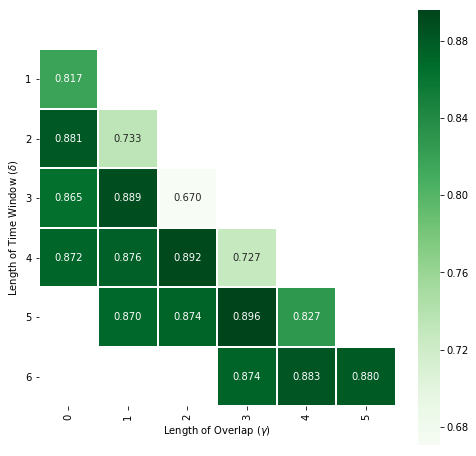

In [410]:
correlations = TW_correlations(field_name, client[__db_name][experiment_collection_name])

tmp = max(correlations, key=lambda x:x['mean'])
best_parameters = [tmp['time_window_size'], tmp['overlap']]
print("\nMAX:", tmp) 
plot_heatmap(pd.DataFrame(correlations).pivot(index="time_window_size", columns="overlap", values="mean"), use_index=True, highlight_diagonal=False, show_values=True, fmt = '.3f', type="upper", filename=RESULTS_DIR+"/correlations_inner-"+field_name+".eps")


#### Scores computation

In [435]:
score_venues = get_score_venues(field_name, best_parameters, __db_name, main_collection_name, experiment_collection_name)


In [436]:
print("Top Venues according to our method")
score_venues.sort_values(by="param", ascending=False)[["venue", "param", "custom_citescore"]][:20]

Top Venues according to our method


,venue,param,custom_citescore
0,J.Math.Phys.,2166.000000,2.494709
1,Phys.Rept.,2146.500000,50.174603
2,Int.J.Mod.Phys.,2139.500000,2.856812
3,Phys.Rev.,2131.000004,8.311272
4,Mod.Phys.Lett.,2118.000000,1.728775
5,Phys.Rev.Lett.,2094.500000,11.155945
6,Commun.Math.Phys.,2080.500000,3.360234
7,Class.Quant.Grav.,2025.000001,5.820988
8,J.Geom.Phys.,2011.500000,4.070175
9,Phys.Lett.,1989.500000,6.807914


In [437]:
print("Top Venues according to our Impact Factor")
score_venues.sort_values(by="custom_citescore", ascending=False)[["venue", "custom_citescore", "param"]][:20]

Top Venues according to our Impact Factor


,venue,custom_citescore,param
1,Phys.Rept.,50.174603,2146.500000
34,Lect.NotesPhys.,27.777778,1.500000
12,Nucl.Phys.Proc.Suppl.,20.584795,1775.999990
23,Fortsch.Phys.,17.711111,138.500000
10,Nucl.Phys.,14.030965,1845.500005
5,Phys.Rev.Lett.,11.155945,2094.500000
44,ChaosSolitonsFractals,8.666667,NaN
3,Phys.Rev.,8.311272,2131.000004
9,Phys.Lett.,6.807914,1989.500000
7,Class.Quant.Grav.,5.820988,2025.000001


#### Correlations with other scores

Spearman correlation with custom Impact Factor: 0.29961389961389956


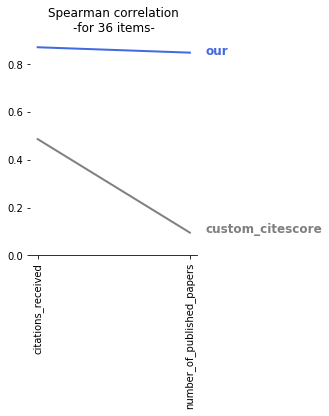

                      feature             score     value
0          citations_received  custom_citescore  0.487161
1          citations_received             param  0.871871
2  number_of_published_papers  custom_citescore  0.095441
3  number_of_published_papers             param  0.849305


In [445]:
print("Spearman correlation with custom Impact Factor:",
      score_venues.dropna()["param"].corr(score_venues.dropna()["custom_citescore"], method='spearman'))
res = []
for item_1 in ["citations_received", "number_of_published_papers"]:
    for item_2 in ["custom_citescore", "param"]:
        tmp_local = score_venues.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
        corr = tmp_local[item_1].corr(tmp_local[item_2], method='spearman')
        res += [{"feature": item_1, "score": item_2, "value": corr}]

plot_local(pd.DataFrame(res).sort_values(by="feature"), len(score_venues.dropna()))
print(pd.DataFrame(res))

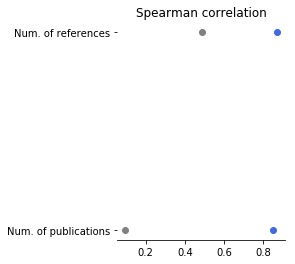

In [446]:
def get_correlations_dict(df):
    res = []
    ####
    item_1 = "citations_received"; item_2 = "custom_citescore"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": "Num. of references", "score": "Impact Factor", "value": corr, "item": "Venues"}]
    ####
    item_1 = "citations_received"; item_2 = "param"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": "Num. of references", "score": "param", "value": corr, "item": "Venues"}]
    ####
    item_1 = "number_of_published_papers"; item_2 = "custom_citescore"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": "Num. of publications", "score": "Impact Factor", "value": corr, "item": "Venues"}]
    ####
    item_1 = "number_of_published_papers"; item_2 = "param"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": "Num. of publications", "score": "param", "value": corr, "item": "Venues"}]
    return res

#total_correlations = total_correlations.append(pd.DataFrame(get_correlations_dict(score_venues)))
plot_correlations(pd.DataFrame(get_correlations_dict(score_venues)).sort_values(by="feature"))

### Authors

In [710]:
field_name = "authors"
iN_index_score = 10

list_of_items = [x['_id'] for x in list(client[__db_name][main_collection_name].aggregate([
    {'$project': {field_name: 1 }}, 
    {'$unwind': '$'+field_name}, 
    {"$match": {field_name: {'$exists': True, '$ne': None} }},
    {'$sortByCount': '$'+field_name },
    {'$match': {'count': {'$gte': 1}}}
]))]
print(len(list_of_items), field_name, "contained on dataset")

list_of_items = [x['author'] for x in list(list_of_authors(range_of_years=initial_years, local_collection=client[__db_name][main_collection_name]))]
print(len(list_of_items), "authors on dataset have published papers between", initial_years[0], "and", initial_years[1])

experiment_collection_name = main_collection_name+"-experiment-"+str(initial_years[0])+"_"+str(initial_years[1])+"-"+str(influence_years[0])+"_"+str(influence_years[1])+"-authors"
experiment_collection_name

11002 authors contained on dataset
3672 authors on dataset have published papers between 1992 and 1994


'papers-experiment-1992_1994-1995_2003-authors'

In [459]:
list(client[__db_name][main_collection_name].aggregate([
    {'$match': {'year': {'$gte': initial_years[0], '$lte': initial_years[1]}}}, 
    {'$project': {field_name: 1 }}, 
    {'$unwind': '$'+field_name}, 
    {"$match": {field_name: {'$exists': True, '$ne': None} }},
    {'$sortByCount': '$'+field_name },
]))

[{'_id': 'E.Elizalde', 'count': 46},
 {'_id': 'S.D.Odintsov', 'count': 42},
 {'_id': 'A.A.Tseytlin', 'count': 29},
 {'_id': 'S.Majid', 'count': 29},
 {'_id': 'H.J.deVega', 'count': 28},
 {'_id': 'E.Witten', 'count': 25},
 {'_id': 'C.N.Pope', 'count': 25},
 {'_id': 'M.Martellini', 'count': 23},
 {'_id': 'M.Henneaux', 'count': 22},
 {'_id': 'A.Morozov', 'count': 20},
 {'_id': 'R.R.Khuri', 'count': 20},
 {'_id': 'A.Strominger', 'count': 20},
 {'_id': 'A.Sen', 'count': 20},
 {'_id': 'R.Jackiw', 'count': 19},
 {'_id': 'H.Saleur', 'count': 19},
 {'_id': 'E.Sezgin', 'count': 18},
 {'_id': 'A.L.Larsen', 'count': 18},
 {'_id': 'H.Lu', 'count': 17},
 {'_id': 'J.Gervais', 'count': 17},
 {'_id': 'L.Susskind', 'count': 17},
 {'_id': 'I.Antoniadis', 'count': 17},
 {'_id': "V.I.Man'ko", 'count': 17},
 {'_id': 'P.Etingof', 'count': 16},
 {'_id': 'R.Kallosh', 'count': 16},
 {'_id': 'H.Aratyn', 'count': 16},
 {'_id': 'E.Kiritsis', 'count': 16},
 {'_id': 'G.W.Semenoff', 'count': 16},
 {'_id': 'S.P.Sorell

In [492]:
create_our_scores(list_of_items, __db_name, experiment_collection_name, influence_years, max_time_window_size)

Documents in collection papers-experiment-1992_1994-1995_2003-authors: 0 

TW: 1 OV: 0 th: 0 - start @ Thu Jan 31 16:04:58 2019
TW: 2 OV: 0 th: 1 - start @ Thu Jan 31 16:04:58 2019
TW: 2 OV: 1 th: 2 - start @ Thu Jan 31 16:04:58 2019
TW: 3 OV: 0 th: 3 - start @ Thu Jan 31 16:04:58 2019
TW: 3 OV: 1 th: 4 - start @ Thu Jan 31 16:04:58 2019
TW: 3 OV: 2 th: 5 - start @ Thu Jan 31 16:04:58 2019
TW: 4 OV: 0 th: 6 - start @ Thu Jan 31 16:04:58 2019
TW: 4 OV: 1 th: 7 - start @ Thu Jan 31 16:04:58 2019
TW: 4 OV: 2 th: 8 - start @ Thu Jan 31 16:04:58 2019
TW: 4 OV: 3 th: 9 - start @ Thu Jan 31 16:04:58 2019
TW: 4 OV: 0 th: 6 - end @ Thu Jan 31 16:22:16 2019 - total time 0:17:18 - documents 3672 - scores: 2362
TW: 5 OV: 1 th: 6 - start @ Thu Jan 31 16:22:16 2019
TW: 4 OV: 1 th: 7 - end @ Thu Jan 31 16:22:17 2019 - total time 0:17:19 - documents 3672 - scores: 2380
TW: 5 OV: 2 th: 7 - start @ Thu Jan 31 16:22:17 2019
TW: 3 OV: 0 th: 3 - end @ Thu Jan 31 16:24:18 2019 - total time 0:19:20 - documen

#### Select parameters
Select parameters with higher correlation with the other ones

### Considering the 2639 items having at least one parameter

MAX: {'experiment': '4 - 2', 'mean': 0.8991676059153563, 'std': 0.06923289441468304, 'time_window_size': 4, 'overlap': 2}


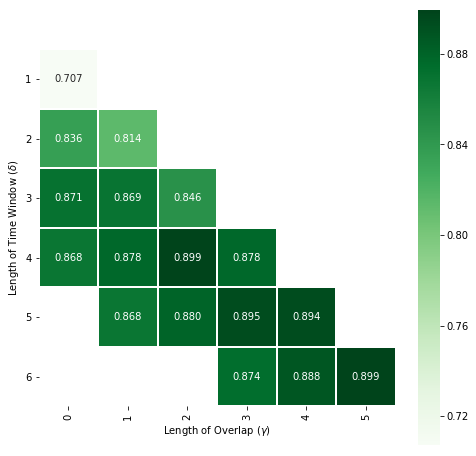

In [690]:
correlations = TW_correlations(field_name, client[__db_name][experiment_collection_name])

tmp = max(correlations, key=lambda x:x['mean'])
best_parameters = [tmp['time_window_size'], tmp['overlap']]
print("\nMAX:", tmp) 
plot_heatmap(pd.DataFrame(correlations).pivot(index="time_window_size", columns="overlap", values="mean"), use_index=True, highlight_diagonal=False, show_values=True, fmt = '.3f', type="upper", filename=RESULTS_DIR+"/correlations_inner-"+field_name+".eps")


#### Scores computation

In [712]:
create_other_indexes_authors(field_name, list_of_items, iN_index_score, __db_name, main_collection_name, experiment_collection_name, initial_years, influence_years, max_time_window_size)


Start execution


Exiting Main Thread

 ### END of procedure! - Total Execution: 0:01:05


In [713]:
score_authors = get_score_authors(field_name, best_parameters, iN_index_score, __db_name, main_collection_name, experiment_collection_name)


In [714]:
print("Top authors, over", len(score_authors.dropna()), "authors, according to our method")
score_authors.sort_values(by=["param","number_of_papers_local"], ascending=[False, True])[:60]

Top authors, over 2450 authors, according to our method


,author,g_index,g_index_local,h_index,h_index_local,i10_index,i10_index_local,m_index,m_index_local,overlap,param,time_window_size,range_of_years,year_first,year_last,range_of_years_local,year_first_local,year_last_local,number_of_papers,number_of_papers_local
0,C.Vafa,94,94,54,54,101,101,102.5,102.5,2,1994.500002,4,11,1992,2003,11,1992,2003,113,113
1,J.Polchinski,55,54,34,34,46,46,74.5,74.5,2,1993.500006,4,11,1992,2003,11,1992,2003,55,55
2,A.Sen,84,84,47,47,86,86,102.0,102.0,2,1979.000003,4,11,1992,2003,11,1992,2003,91,91
3,P.K.Townsend,72,72,35,35,67,67,81.0,81.0,2,1963.500000,4,11,1992,2003,11,1992,2003,85,85
4,M.J.Duff,51,51,28,28,41,41,67.0,67.0,2,1953.500002,4,11,1992,2003,11,1992,2003,54,54
5,E.Witten,110,107,63,63,100,100,148.0,148.0,2,1938.500002,4,11,1992,2003,11,1992,2003,110,110
6,C.M.Hull,48,48,21,21,36,36,50.0,50.0,2,1904.000000,4,10,1992,2002,10,1992,2002,58,58
7,J.X.Lu,24,23,13,13,16,16,26.0,26.0,2,1900.000000,4,10,1992,2002,10,1992,2002,24,24
8,N.Seiberg,67,66,49,49,64,64,113.0,113.0,2,1897.999999,4,11,1992,2003,11,1992,2003,67,67
9,R.R.Khuri,34,34,15,15,19,19,38.0,38.0,2,1888.000005,4,10,1992,2002,10,1992,2002,44,44


In [715]:
print("Top authors, over", len(score_authors.dropna()), "authors, according to h-index")
score_authors.sort_values(by=["h_index_local","number_of_papers_local"], ascending=[False, True])[:60]

Top authors, over 2450 authors, according to h-index


,author,g_index,g_index_local,h_index,h_index_local,i10_index,i10_index_local,m_index,m_index_local,overlap,param,time_window_size,range_of_years,year_first,year_last,range_of_years_local,year_first_local,year_last_local,number_of_papers,number_of_papers_local
5,E.Witten,110,107,63,63,100,100,148.0,148.0,2,1938.500002,4,11,1992,2003,11,1992,2003,110,110
0,C.Vafa,94,94,54,54,101,101,102.5,102.5,2,1994.500002,4,11,1992,2003,11,1992,2003,113,113
8,N.Seiberg,67,66,49,49,64,64,113.0,113.0,2,1897.999999,4,11,1992,2003,11,1992,2003,67,67
2,A.Sen,84,84,47,47,86,86,102.0,102.0,2,1979.000003,4,11,1992,2003,11,1992,2003,91,91
46,A.A.Tseytlin,70,70,42,42,103,103,79.5,79.5,2,1492.000006,4,11,1992,2003,11,1992,2003,126,126
58,A.Strominger,75,75,39,39,68,68,96.0,96.0,2,1407.999995,4,11,1992,2003,11,1992,2003,75,75
90,I.R.Klebanov,76,74,38,38,68,68,81.0,81.0,2,1199.999999,4,11,1992,2003,11,1992,2003,76,76
47,M.R.Douglas,56,56,36,36,52,52,85.0,85.0,2,1489.999998,4,11,1992,2003,11,1992,2003,56,56
10,L.Susskind,66,65,36,36,55,55,92.5,92.5,2,1888.000002,4,11,1992,2003,11,1992,2003,66,66
19,R.Kallosh,55,55,36,36,63,63,54.5,54.5,2,1786.999999,4,11,1992,2003,11,1992,2003,90,90


Spearman correlation with h-index_local: 0.4884099748223652


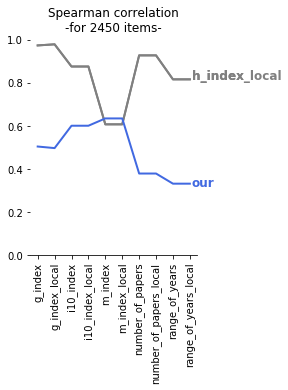

                   feature          score     value
0           range_of_years  h_index_local  0.815289
1           range_of_years        h_index  0.815289
2           range_of_years          param  0.330545
3         number_of_papers  h_index_local  0.926726
4         number_of_papers        h_index  0.926726
5         number_of_papers          param  0.377650
6                  g_index  h_index_local  0.972959
7                  g_index        h_index  0.972959
8                  g_index          param  0.503163
9                  m_index  h_index_local  0.606274
10                 m_index        h_index  0.606274
11                 m_index          param  0.633719
12               i10_index  h_index_local  0.874971
13               i10_index        h_index  0.874971
14               i10_index          param  0.599799
15    range_of_years_local  h_index_local  0.815289
16    range_of_years_local        h_index  0.815289
17    range_of_years_local          param  0.330545
18  number_o

In [716]:
print("Spearman correlation with h-index_local:",
      score_authors.dropna()["param"].corr(score_authors.dropna()["h_index_local"], method='spearman'))

res = []
for item_1 in ["range_of_years", "number_of_papers", "g_index", "m_index", "i"+str(iN_index_score)+"_index", "range_of_years_local", "number_of_papers_local", "g_index_local", "m_index_local", "i"+str(iN_index_score)+"_index_local"]:#["year_first", "year_first_local", ]
    for item_2 in ["h_index_local", "h_index", "param"]:
        tmp_local = score_authors.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
        corr = tmp_local[item_1].corr(tmp_local[item_2], method='spearman')
        res += [{"feature": item_1, "score": item_2, "value": corr}]

plot_local(pd.DataFrame(res).sort_values(by="feature"), len(score_authors.dropna()))
print(pd.DataFrame(res))

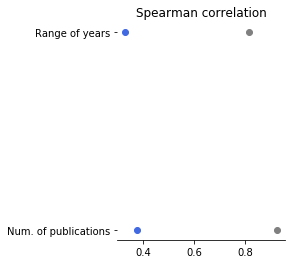

In [562]:
def get_correlations_dict(df):
    res = []
    ####
    item_1 = "range_of_years_local"; item_2 = "h_index_local"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": "Range of years", "score": "h-index", "value": corr, "item": "Authors"}]
    ####
    item_1 = "range_of_years_local"; item_2 = "param"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": "Range of years", "score": "param", "value": corr, "item": "Authors"}]
    ####
    item_1 = "number_of_papers_local"; item_2 = "h_index_local"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": "Num. of publications", "score": "h-index", "value": corr, "item": "Authors"}]
    ####
    item_1 = "number_of_papers_local"; item_2 = "param"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": "Num. of publications", "score": "param", "value": corr, "item": "Authors"}]
    return res

#total_correlations = total_correlations.append(pd.DataFrame(get_correlations_dict(score_authors)))
plot_correlations(pd.DataFrame(get_correlations_dict(score_authors)).sort_values(by="feature"))

### Publications

In [592]:
field_name = "_id"

list_of_items = [x['_id'] for x in list(client[__db_name][main_collection_name].find({'year': {'$gte': initial_years[0], '$lte': initial_years[1]}}, {'_id': 1} ))]
print(len(list_of_items), "papers published between", initial_years[0], "and", initial_years[1], "on dataset")
experiment_collection_name = main_collection_name+"-experiment-"+str(initial_years[0])+"_"+str(initial_years[1])+"-"+str(influence_years[0])+"_"+str(influence_years[1])+"-"+field_name
experiment_collection_name

5802 papers published between 1992 and 1994 on dataset


'papers-experiment-1992_1994-1995_2003-_id'

In [597]:
list(client[__db_name][main_collection_name].aggregate([
    {'$match': {'year': {'$gte': initial_years[0], '$lte': initial_years[1]}}}, 
    {'$project': {field_name: 1, 'cited_by': '$cited_by._id' }}, 
    {'$unwind': '$cited_by'}, 
    {'$sortByCount': '$'+field_name },
    {'$limit': 10}
]))

[{'_id': 9407087, 'count': 1299},
 {'_id': 9408099, 'count': 1006},
 {'_id': 9410167, 'count': 748},
 {'_id': 9409089, 'count': 427},
 {'_id': 9412184, 'count': 426},
 {'_id': 9401139, 'count': 421},
 {'_id': 9411149, 'count': 411},
 {'_id': 9204099, 'count': 380},
 {'_id': 9301042, 'count': 344},
 {'_id': 9411048, 'count': 314}]

In [612]:
create_our_scores(field_name, list_of_items, __db_name, experiment_collection_name, influence_years, max_time_window_size)


Documents in collection papers-experiment-1992_1994-1995_2003-_id: 0 

TW: 1 OV: 0 th: 0 - start @ Fri Feb  1 16:00:35 2019
TW: 2 OV: 0 th: 1 - start @ Fri Feb  1 16:00:35 2019
TW: 2 OV: 1 th: 2 - start @ Fri Feb  1 16:00:35 2019
TW: 3 OV: 0 th: 3 - start @ Fri Feb  1 16:00:35 2019
TW: 3 OV: 1 th: 4 - start @ Fri Feb  1 16:00:35 2019
TW: 3 OV: 2 th: 5 - start @ Fri Feb  1 16:00:35 2019
TW: 4 OV: 0 th: 6 - start @ Fri Feb  1 16:00:35 2019
TW: 4 OV: 1 th: 7 - start @ Fri Feb  1 16:00:35 2019
TW: 4 OV: 2 th: 8 - start @ Fri Feb  1 16:00:35 2019
TW: 4 OV: 3 th: 9 - start @ Fri Feb  1 16:00:35 2019
TW: 4 OV: 1 th: 7 - end @ Fri Feb  1 16:23:00 2019 - total time 0:22:25 - documents 5802 - scores: 3100
TW: 5 OV: 1 th: 7 - start @ Fri Feb  1 16:23:00 2019
TW: 4 OV: 0 th: 6 - end @ Fri Feb  1 16:23:09 2019 - total time 0:22:34 - documents 5802 - scores: 3072
TW: 5 OV: 2 th: 6 - start @ Fri Feb  1 16:23:09 2019
TW: 3 OV: 0 th: 3 - end @ Fri Feb  1 16:24:56 2019 - total time 0:24:21 - documents 5

#### Select parameters
Select parameters with higher correlation with the other ones

### Considering the 3542 items having at least one parameter

MAX: {'experiment': '4 - 2', 'mean': 0.8725751370666742, 'std': 0.0695724405799697, 'time_window_size': 4, 'overlap': 2}


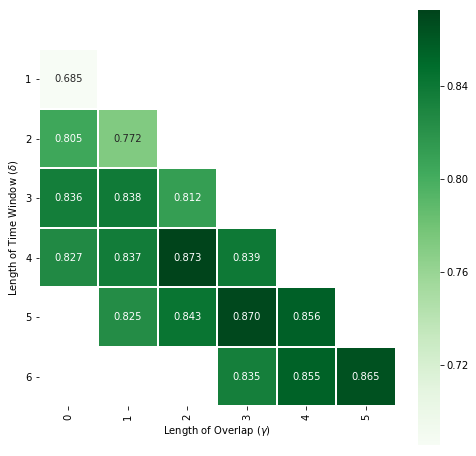

In [616]:
correlations = TW_correlations("original_id", client[__db_name][experiment_collection_name])

tmp = max(correlations, key=lambda x:x['mean'])
best_parameters = [tmp['time_window_size'], tmp['overlap']]
print("\nMAX:", tmp)
plot_heatmap(pd.DataFrame(correlations).pivot(index="time_window_size", columns="overlap", values="mean"), use_index=True, highlight_diagonal=False, show_values=True, fmt = '.3f', type="upper", filename=RESULTS_DIR+"/correlations_inner-"+field_name+".eps")


#### Scores computation

In [643]:
def get_score_papers(main_topic, best_parameters, __db_name, main_collection_name, experiment_collection_name):
    #get score for each paper
    tmp = pd.DataFrame(list(get_topics_score("number_of_new_authors", 0, best_parameters[0], best_parameters[1], main_topic, local_collection=client[__db_name][experiment_collection_name])))[[main_topic, "param"]].rename(columns={main_topic: '_id'})
    #get authors and number of citations for each paper
    tmp = tmp.merge(pd.DataFrame(list(client[__db_name][main_collection_name].aggregate([
        {'$match': {'year': {'$gte': initial_years[0], '$lte': initial_years[1]} }}, 
        {'$project': {'_id': 1, 'authors': 1, 'number_of_citations': { '$size': '$cited_by' } }}, 
        {'$unwind': '$authors' }, 
    ]))).rename(columns={'authors': 'author'}), how="left")
    #get range of years of publication for each author
    tmp = tmp.merge(pd.DataFrame(list(list_of_authors(local_collection=client[__db_name][main_collection_name])))[["author", "range_of_years"]], how="left")
    tmp = tmp.merge(pd.DataFrame(list(list_of_authors(range_of_years=[initial_years[0], influence_years[1]], local_collection=client[__db_name][main_collection_name]))).rename(columns={"range_of_years": "range_of_years_local"})[["author", "range_of_years_local"]], how="left")
    #get h-index for each author
    tmp = tmp.merge(
        pd.DataFrame(list(client[__db_name][main_collection_name+"-experiment-"+str(initial_years[0])+"_"+str(initial_years[1])+"-"+str(influence_years[0])+"_"+str(influence_years[1])+"-"+"authors"].aggregate([
            {'$project': { '_id': 0, 'authors': 1, 'h_index': 1, 'h_index_local': 1 }},
            {'$group': { '_id': '$authors', 'h_index': {'$first': '$h_index'}, 'h_index_local': {'$first': '$h_index_local'} }},
            {'$project': { '_id': 0, 'author': '$_id', 'h_index': 1, 'h_index_local': 1 }},
        ])))
    , how="left")
    #for each publication, keep only the max value of each feature calculted on its authors
    tmp = tmp.drop(columns=["author"]).groupby("_id").max().reset_index()
    #add titles
    tmp = pd.DataFrame(list(client[__db_name][main_collection_name].find({},{ '_id': 1, 'title': 1}))).merge(tmp, how="right")
    return tmp.sort_values(by="param", ascending=False).reset_index(drop=True)

score_papers = get_score_papers("original_id", best_parameters, __db_name, main_collection_name, experiment_collection_name)


In [646]:
print("Top Documents by our method")
score_papers.sort_values(by="param", ascending=False)[["_id", "title", "param", "number_of_citations"]][:40]


Top Documents by our method


,_id,title,param,number_of_citations
0,9408074,A Strong Coupling Test of S-Duality,1919.000003,290
1,9410167,Unity of Superstring Dualities,1908.000000,748
2,9402032,"Dyon - Monopole Bound States, Self-Dual Harmon...",1876.999996,240
3,9407087,"Monopole Condensation, And Confinement In N=2 ...",1869.999998,1299
4,9412184,String Solitons,1867.999998,426
5,9407031,Combinatorics of Boundaries in String Theory,1857.000009,136
6,9409089,The World as a Hologram,1846.000004,427
7,9402002,Strong-Weak Coupling Duality in Four Dimension...,1816.500031,282
8,9307049,Vacuum interpolation in supergravity via super...,1804.000010,172
9,9401139,Target Space Duality in String Theory,1756.500005,421


In [647]:
print("Top Documents by number of citations received")
score_papers.sort_values(by="number_of_citations", ascending=False)[["_id", "title", "number_of_citations", "param"]][:40]


Top Documents by number of citations received


,_id,title,number_of_citations,param
3,9407087,"Monopole Condensation, And Confinement In N=2 ...",1299,1869.999998
13,9408099,"Monopoles, Duality and Chiral Symmetry Breakin...",1006,1720.500004
1,9410167,Unity of Superstring Dualities,748,1908.000000
6,9409089,The World as a Hologram,427,1846.000004
4,9412184,String Solitons,426,1867.999998
9,9401139,Target Space Duality in String Theory,421,1756.500005
15,9411149,Electric-Magnetic Duality in Supersymmetric No...,411,1662.000000
26,9204099,The Black Hole in Three Dimensional Space Time,380,1572.499997
18,9301042,Phases of $N=2$ Theories In Two Dimensions,344,1648.000003
42,9411048,Simple Singularities and N=2 Supersymmetric Ya...,314,1389.500004


Spearman correlation with number of references: 0.6039262358616203


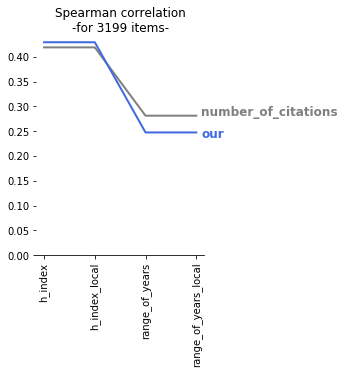

                feature                score     value
0         h_index_local  number_of_citations  0.418857
1         h_index_local                param  0.429200
2               h_index  number_of_citations  0.418857
3               h_index                param  0.429200
4  range_of_years_local  number_of_citations  0.281156
5  range_of_years_local                param  0.247374
6        range_of_years  number_of_citations  0.281156
7        range_of_years                param  0.247374


In [650]:
print("Spearman correlation with number of references:",
      score_papers.dropna()["param"].corr(score_papers.dropna()["number_of_citations"], method='spearman'))
res = []
for item_1 in ["h_index_local", "h_index", "range_of_years_local", "range_of_years"]:
    for item_2 in ["number_of_citations", "param"]:
        tmp_local = score_papers.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
        corr = tmp_local[item_1].corr(tmp_local[item_2], method='spearman')
        res += [{"feature": item_1, "score": item_2, "value": corr}]

plot_local(pd.DataFrame(res).sort_values(by="feature"), len(score_papers.dropna()))
print(pd.DataFrame(res))


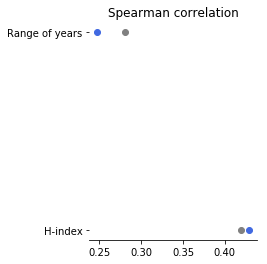

In [651]:
def get_correlations_dict(df):
    res = []
    ####
    item_1 = "range_of_years_local"; item_2 = "number_of_citations"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": "Range of years", "score": "h-index", "value": corr, "item": "Documents"}]
    ####
    item_1 = "range_of_years_local"; item_2 = "param"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": "Range of years", "score": "param", "value": corr, "item": "Documents"}]
    ####
    item_1 = "h_index_local"; item_2 = "number_of_citations"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": "H-index", "score": "h-index", "value": corr, "item": "Documents"}]
    ####
    item_1 = "h_index_local"; item_2 = "param"
    df_local = df.dropna()[[item_1, item_2]].sort_values(by=item_2, ascending=False)
    corr = df_local[item_1].corr(df_local[item_2], method='spearman')
    res += [{"feature": "H-index", "score": "param", "value": corr, "item": "Documents"}]
    return res

#total_correlations = total_correlations.append(pd.DataFrame(get_correlations_dict(score_papers)))
plot_correlations(pd.DataFrame(get_correlations_dict(score_papers)).sort_values(by="feature"))